In [2]:
import pandas as pd
df = pd.read_csv("/mnt/ssd500/hungbnt/DocumentClassification/data/FWD_and_Samsung.csv")
df["img_path"][0]

'/mnt/ssd500/hungbnt/DocumentClassification/data/SamsungIMG/XNDY/XNDY_4.jpg'

# Visualize bbox and text

In [ ]:
from PIL import ImageFont, ImageDraw, Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from externals.ocr.utils import read_ocr_result_from_txt, visualize_bbox_and_label
img_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS01/1.pdf.jpg"
ocr_path = "/mnt/ssd500/hungbnt/DocumentClassification/results/ocr/POS01/1.pdf.txt"
bboxes, texts = read_ocr_result_from_txt(ocr_path)
img = cv2.imread(img_path)
img = visualize_bbox_and_label(img, bboxes, texts, is_vnese=True)
plt.figure(figsize=(20,20), dpi=200)
plt.imshow(img)
plt.show()


# Pseudo classify CCCD/CMND

In [4]:
from pathlib import Path
from rule_basedoc_classifier_test import RuleBaseDocClassifier
from tqdm import tqdm
from src.tools.utils import construct_file_path
import shutil
# DET_CFG = "/home/sds/datnt/mmdetection/logs/textdet-fwd/yolox_s_8x8_300e_cocotext_1280.py"
# DET_CKPT = "/home/sds/datnt/mmdetection/logs/textdet-fwd/best_bbox_mAP_epoch_100.pth"
# CLS_CFG = "/home/sds/datnt/mmocr/logs/satrn_big_2022-10-31/satrn_big.py"
# CLS_CKPT = "/home/sds/datnt/mmocr/logs/satrn_big_2022-10-31/best.pth"
DATA_DIR = Path("/mnt/hdd2T/AICR/Projects/TD_AI_based_Text_Extraction_Solution/PV2/Dataset/KIE_Identity_Card/val")
OCR_DIR = Path("/home/sds/hungbnt/KIE_pretrained/data/pseudo_label/300_new_cls_magic")
SAVE_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/data/ID_CARD")

In [7]:
for ocr_path in tqdm(OCR_DIR.glob("*.txt")):
    _lbboxes, lwords = read_ocr_result_from_txt(ocr_path)
    pred = RuleBaseDocClassifier.classify(lwords)
    save_dir = SAVE_DIR.joinpath(pred)
    if not save_dir.is_dir():
        save_dir.mkdir()
    img_path = construct_file_path(str(DATA_DIR), ocr_path, ext='.jpg')
    shutil.copy(img_path, save_dir)


300it [00:06, 47.95it/s]


# Error analysis for rule base classifier

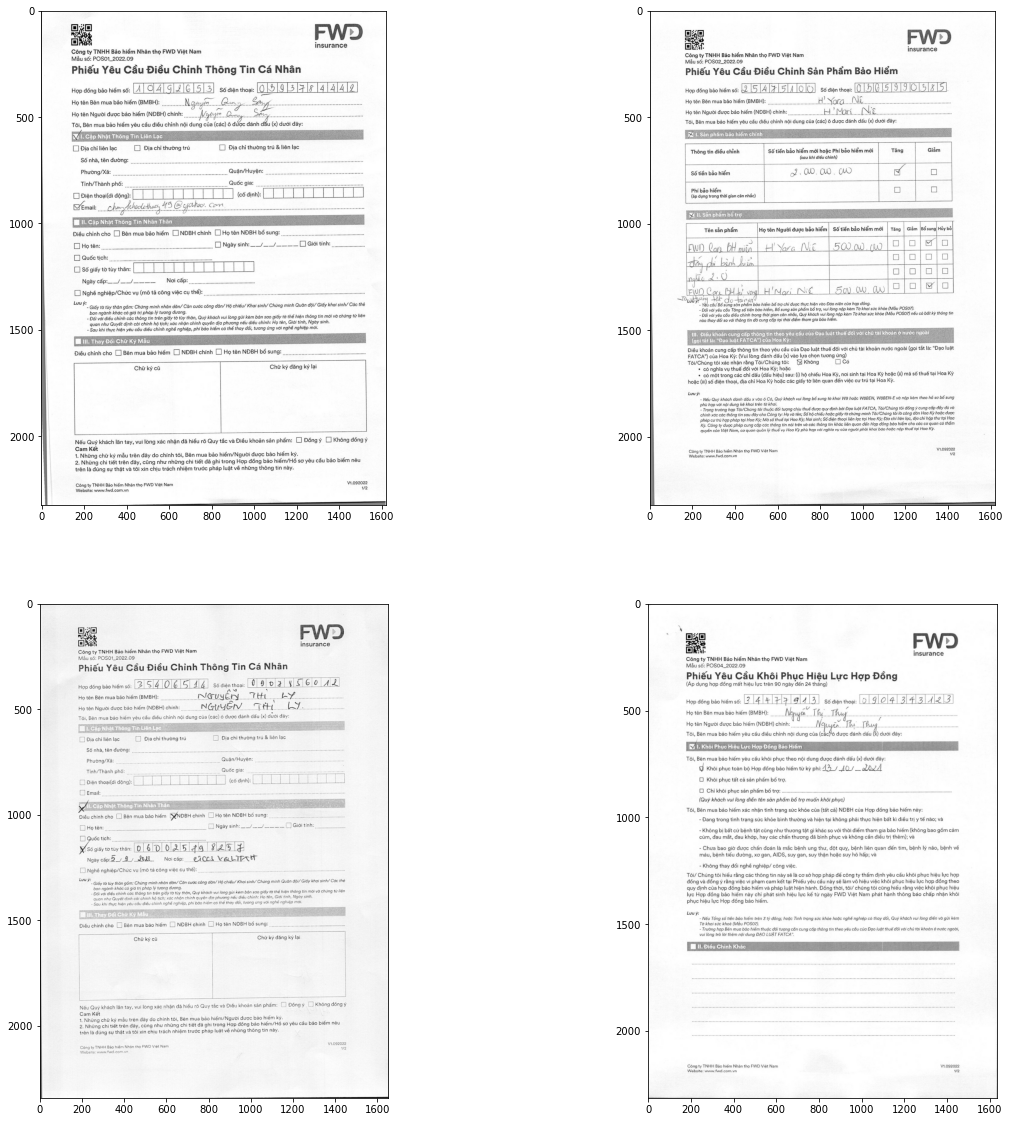

In [34]:
# base_img_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS02/1.pdf.jpg"
base_img_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS01/1_PDFsam_Scan.pdf.jpg"
base_img_path2 = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS02/1.pdf.jpg"
err_img_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS01/1.pdf.jpg"
err_img_path2 = "/mnt/ssd500/hungbnt/DocumentClassification/data/FWD/POS04/27.pdf.jpg"
import cv2
import matplotlib.pyplot as plt
err_img = cv2.imread(err_img_path)
err_img2 = cv2.imread(err_img_path2)
base_img = cv2.imread(base_img_path)
base_img2 = cv2.imread(base_img_path2)
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(base_img)
plt.subplot(222)
plt.imshow(base_img2)
plt.subplot(223)
plt.imshow(err_img)
plt.subplot(224)
plt.imshow(err_img2)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.hist(base_img.ravel(),256,[0,256])
plt.subplot(222)
plt.hist(base_img2.ravel(),256,[0,256])
plt.subplot(223)
plt.hist(err_img.ravel(),256,[0,256])
plt.subplot(224)
plt.hist(err_img2.ravel(),256,[0,256])
plt.show()


In [3]:
import numpy as np
type(np.array([0,0])) is np.ndarray

True

In [ ]:
# Hàm build_is_hist để tính histogram cho 2 kênh S, V của ảnh đầu vào
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy, scipy.misc, scipy.signal
import cv2
def build_is_hist(img):
    ### YOUR CODE HERE ###
    # Lấy các thông số height, width, channel của ảnh đầu vào
    hei = img.shape[0]
    wid = img.shape[1]
    ch = img.shape[2]
    ### YOUR CODE HERE ###

    ### YOUR CODE HERE ###
    # Khởi tạo một ảnh đen RGB có kích thước (height+4, width+4, channel), chuyển sang không gian hsv rồi scale về khoảng [0,255]
    Img = np.zeros((hei+4, wid+4, ch))
    for i in range(ch):
        Img[:,:,i] = np.pad(img[:,:,i], (2,2), 'edge')
    hsv = (matplotlib.colors.rgb_to_hsv(Img))
    hsv[:,:,0] = hsv[:,:,0] * 255
    hsv[:,:,1] = hsv[:,:,1] * 255
    hsv[hsv>255] = 255
    hsv[hsv<0] = 0
    hsv = hsv.astype(np.uint8).astype(np.float64)
    ### YOUR CODE HERE ###

    fh = np.array([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
    fv = fh.conj().T
    
    ### YOUR CODE HERE ###
    # Tách 3 kênh H, S, V
    H = hsv[:,:,0]
    S = hsv[:,:,1]
    I = hsv[:,:,2]
    ### YOUR CODE HERE ###

    ### YOUR CODE HERE ###
    # Lần lượt rotate fh, fv 180 độ rồi convolve với kênh V
    dIh = scipy.signal.convolve2d(I, np.rot90(fh, 2), mode='same')
    dIv = scipy.signal.convolve2d(I, np.rot90(fv, 2), mode='same')
    ### YOUR CODE HERE ###

    dIh[dIh==0] = 0.00001
    dIv[dIv==0] = 0.00001
    dI = np.sqrt(dIh**2+dIv**2).astype(np.uint32)
    di = dI[2:hei+2,2:wid+2]
    
    ### YOUR CODE HERE ###
    # Lần lượt rotate fh, fv 180 độ rồi convolve với kênh V
    dSh = scipy.signal.convolve2d(S, np.rot90(fh, 2), mode='same')
    dSv = scipy.signal.convolve2d(S, np.rot90(fv, 2), mode='same')
    ### YOUR CODE HERE ###

    dSh[dSh==0] = 0.00001
    dSv[dSv==0] = 0.00001
    dS = np.sqrt(dSh**2+dSv**2).astype(np.uint32)
    ds = dS[2:hei+2,2:wid+2]

    i = I[2:hei+2,2:wid+2].astype(np.uint8)
    
    Rho = np.zeros((hei+4,wid+4))
    for p in range(2,hei+2):
        for q in range(2,wid+2):
            tmpi = I[p-2:p+3,q-2:q+3]
            tmps = S[p-2:p+3,q-2:q+3]
            corre = np.corrcoef(tmpi.flatten('F'),tmps.flatten('F'))
            Rho[p,q] = corre[0,1]
    
    rho = np.abs(Rho[2:hei+2,2:wid+2])
    rho[np.isnan(rho)] = 0
    rd = (rho*ds).astype(np.uint32)
    Hist_I = np.zeros((256,1))
    Hist_S = np.zeros((256,1))
    
    for n in range(0,255):
        temp = np.zeros(di.shape)
        temp[i==n] = di[i==n]
        Hist_I[n+1] = np.sum(temp.flatten('F'))
        temp = np.zeros(di.shape)
        temp[i==n] = rd[i==n]
        Hist_S[n+1] = np.sum(temp.flatten('F'))
    return Hist_I, Hist_S
def dhe(img, alpha=0.5):
    hist_i, hist_s = build_is_hist(img)
    hist_c = alpha*hist_s + (1-alpha)*hist_i
    hist_sum = np.sum(hist_c)
    hist_cum = hist_c.cumsum(axis=0)
    
    hsv = matplotlib.colors.rgb_to_hsv(img)
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    i = hsv[:,:,2].astype(np.uint8)
    
    c = hist_cum / hist_sum
    s_r = (c * 255)
    i_s = np.zeros(i.shape)
    for n in range(0,255):
        i_s[i==n] = s_r[n+1]/255.0
    i_s[i==255] = 1
    hsi_o = np.stack((h,s,i_s), axis=2)
    result = matplotlib.colors.hsv_to_rgb(hsi_o)
    
    result = result * 255
    result[result>255] = 255
    result[result<0] = 0
    return result.astype(np.uint8)
err_img = cv2.resize(err_img, (224,244))
equ = dhe(err_img)
plt.figure(figsize=(20,20))
plt.imshow(err_img)
plt.figure()
plt.hist(equ.ravel(),256,[0,256])
plt.show()


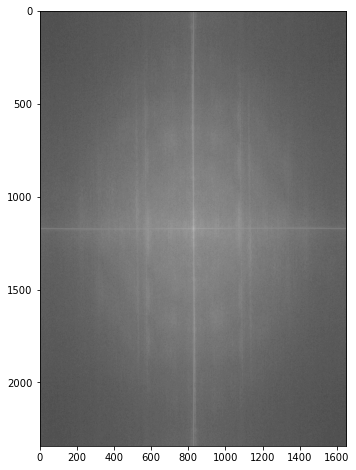

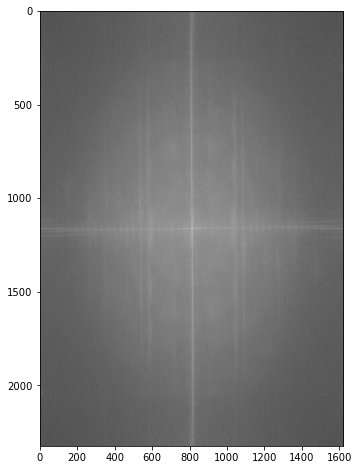

In [37]:
err_img = cv2.imread(err_img_path, 0)
base_img = cv2.imread(base_img_path, 0)

for img in [err_img, base_img]:
    dft = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT) #img.shape x [real, imagine]

    # apply shift of origin from upper left corner to center of image
    dft_shift = np.fft.fftshift(dft)

    magnitude_spectrum = np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])) #magnitude - sqrt(real^2 + imagine^2)
    fig = plt.figure(figsize=(8,8))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.show()

# Convert json coco to df

In [ ]:
import pandas as pd
from src.tools.utils import read_json_file
from pathlib import Path
import os
from src.tools.utils import construct_file_path

json_path = "/mnt/hdd2T/datnt/mmdetData/text/annotations/fwd_batch1.json"
fwd_json = read_json_file(json_path)
val_list = [d["file_name"] for d in fwd_json["images"]]
val_list[0]


In [ ]:
img_dir = Path("/mnt/ssd500/hungbnt/DocumentClassification/data/FWD")
ocr_dir = "/mnt/ssd500/hungbnt/DocumentClassification/results/ocr"
save_dir = "/mnt/ssd500/hungbnt/DocumentClassification/data/"

ddata = {
    "img_path": list(),
    "ocr_path": list(),
    "label": list(),
}
for file_name in val_list:
    doc_cls, img_name = file_name.split("_", 1)    
    img_name, ipage = img_name.rsplit("_", 1)
    if not ipage[0] == "0": #only proceed the first page (ipage =0)
        continue
    err_img_path = img_dir.joinpath(doc_cls, img_name + ".pdf.jpg")
    ddata["img_path"].append(str(err_img_path.as_posix()))
    ddata["ocr_path"].append(construct_file_path(os.path.join(ocr_dir, doc_cls), err_img_path.name, ext=".txt"))
    ddata["label"].append(doc_cls)

df = pd.DataFrame.from_dict(ddata)
df.to_csv(f"{save_dir}/FWD_val.csv", index=False)


# Generate dataframe from data_dir

In [2]:
from src.tools.utils import construct_file_path
from pathlib import Path
import pandas as pd
def create_df_dataloader_from_data_dir(data_dir: str, ocr_dir: str):
    data_dir = Path(data_dir)
    ddata = {
        "img_path": list(),
        "ocr_path": list(),
        "label": list(),
    }
    for d in data_dir.glob('*'):
        for f in d.glob('*.jpg'):
            ddata["label"].append(d.name)
            ddata["img_path"].append(str(f.as_posix()))
            ddata["ocr_path"].append(construct_file_path(os.path.join(ocr_dir, d.name), f.name, ext=".txt"))

    df = pd.DataFrame.from_dict(ddata)
    return df
data_dir = "/mnt/ssd500/hungbnt/DocumentClassification/data/SamsungPhone/scan"
ocr_dir = "/mnt/ssd500/hungbnt/DocumentClassification/results/ocr/Samsung"
save_dir = "/mnt/ssd500/hungbnt/DocumentClassification/data/"
df = create_df_dataloader_from_data_dir(data_dir, ocr_dir)
df.to_csv(f"{save_dir}/Samsung_phone_scan.csv", index=False)


# Convert pdf to imgs

In [ ]:
from pathlib import Path
from pdf2image import convert_from_path

DATA_DIR = Path("/mnt/hdd2T/AICR/Projects/FWD/Phase1/Completed_forms_SAMSUNG/")
SAVE_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/data")

# %% convert pdf to images
for d in DATA_DIR.glob('*'):
    SAVE_DIR_SUB = SAVE_DIR.joinpath(d.name)
    if not SAVE_DIR_SUB.is_dir():
        SAVE_DIR_SUB.mkdir()
    for f in d.glob('*.pdf'):
        images = convert_from_path(str(f), grayscale=False)
        err_img_path = str(f)
        images[0].save(str(SAVE_DIR_SUB.joinpath(f.stem + '.jpg')), 'JPEG')  # save only the first pages
        break
    break

In [4]:
from pathlib import Path
from pdf2image import convert_from_path
from tqdm import tqdm
DATA_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/data/SamsungPDF")
SAVE_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/data/SamsungIMG")


# %% convert pdf to images
for f in DATA_DIR.glob('*.pdf'):
    SAVE_DIR_SUB = SAVE_DIR.joinpath(f.stem)
    if not SAVE_DIR_SUB.is_dir():
        SAVE_DIR_SUB.mkdir()
    images = convert_from_path(str(f), grayscale=False)
    for i in tqdm(range(len(images))):
        images[i].save(str(SAVE_DIR_SUB.joinpath(f.stem + f'_{i}.jpg')), 'JPEG')  # save only the first pages

100%|██████████| 43/43 [00:04<00:00, 10.39it/s]


# Visualize pdf

In [ ]:
# %% test fitz
import fitz
from PIL import Image
#
# pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/Sample_input/Case_1_tach_roi-toan-bo/Phieu-yeu-cau-dieu-chinh-hop-dong.pdf"
# pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/Sample_input/Case_1_tach_roi-toan-bo/CMND.pdf"
# pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/Sample_input/Case_1_tach_roi-toan-bo/Giay_khai_sinh.pdf"
# pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/Sample_input/Case_1_tach_roi-toan-bo/Giay_xac_nhan.pdf"
# pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/Sample_input/Case_1_tach_roi-toan-bo/Hoa_don.pdf"
pdf_path = "/mnt/ssd500/hungbnt/DocumentClassification/data/AIChatbot user feedbacks_from VIB - Copy.pdf"


def convert_pdf_to_image(fic):
    # open your file
    doc = fitz.open(fic)
    # iterate through the pages of the document and create a RGB image of the page
    imgs = []
    for page in doc:
        pix = page.get_pixmap(colorspace="RGB")
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        imgs.append(img)
    return imgs


imgs = convert_pdf_to_image(pdf_path)
print(len(imgs))
imgs[0].size
print(imgs[0])
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.imshow(imgs[0])

# EDA

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
# DATA_DIR = Path("/mnt/hdd2T/AICR/Projects/FWD/Phase1/Completed_forms_SAMSUNG/")
DATA_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/data")

In [ ]:
#https://stackoverflow.com/questions/3883138/how-do-i-read-the-number-of-files-in-a-folder-using-python
print('number of types documents',len(list(DATA_DIR.glob('*')))) ## 1
print ('number of total documents', len(list(DATA_DIR.glob('**/*')))) ## 2
ndocs = {d.name: len(list(d.glob('*'))) for d in DATA_DIR.iterdir()}
print('number of documents of each type', ndocs)

#https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
D=dict(sorted(ndocs.items()))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

#number of types documents 7
#number of total documents 683
#number of documents of each type {'POS06': 65, 'POS01': 140, 'POS04': 201, 'POS02': 60, 'POS03': 90, 'POS08': 60, 'POS05': 60}

In [ ]:
# from pdf2image import convert_from_path
# from collections import defaultdict

# npages = {}
# # Store Pdf with convert_from_path function
# for d in DATA_DIR.glob('*'):
#     npages[d.name] = defaultdict(list)
#     for f in d.glob('*'):
#         images = convert_from_path(str(f))
#         npages[d.name][f.name].append(len(images))
# print(npages)

### => npages = 2 for each pdf

In [ ]:
from collections import defaultdict
def read_txt_lines(file_path):
    with open(file_path, 'r') as fp:
        lines = fp.read().splitlines()
    return lines
    
OCR_DIR = Path("/mnt/ssd500/hungbnt/DocumentClassification/results/ocr")
nwords = {}
for d in OCR_DIR.glob('*'):
    nwords[d.name] = defaultdict(list)
    for f in d.glob('*'):
        lines = read_txt_lines(str(f))
        nwords[d.name][f.name] = len(lines)
        break
print(nwords.keys())

In [ ]:
D = {k:list(v.values())[0] for k,v in sorted(nwords.items())}
print(D)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()


# Find max_length of subwords respect to how many words (to see what would be the real input of the model)

In [ ]:
from transformers import (
    LayoutLMv2ForSequenceClassification, LayoutXLMTokenizer,
    LayoutLMv2FeatureExtractor, LayoutLMv2Processor, LayoutXLMProcessor
)
from datasets import Dataset
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
import os
import pandas as pd
import cv2
import random
import string
import torch
from PIL import Image

OCR_ROOT = "/mnt/ssd500/hungbnt/DocumentClassification/results/ocr"
DOC_LABELS = ["POS01", "POS02", "POS03", "POS04", "POS05", "POS06", "POS08"]
LABEL2IDX = {DOC_LABELS[i]: i for i in range(len(DOC_LABELS))}
tokenizer = LayoutXLMTokenizer.from_pretrained("/mnt/ssd500/hungbnt/DocumentClassification/weights/tokenizer")
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
processor = LayoutXLMProcessor(feature_extractor, tokenizer)


def preprocess_data(examples, max_seq_length=128):
    # Add custom OCR here
    words = examples['words']
    normalized_word_boxes = examples['bbox']

    assert all([
        len(_words) == len(boxes) 
        for _words, boxes in zip(words, normalized_word_boxes)
    ])

    # Process examples
    images = [Image.open(path).convert("RGB") for path in examples['image_path']]
    encoded_inputs = processor(
        images, padding="max_length", truncation=True, text=words,
        boxes=normalized_word_boxes, max_length=max_seq_length,
    )
    encoded_inputs["labels"] = [LABEL2IDX[label] for label in examples["label"]]
    return encoded_inputs

def _normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def load_ocr_labels(example, ocr_root):
    r"""Load OCR labels, i.e. (word, bbox) pairs, into the input DataFrame containing of columns (image_path, ocr_path, label)"""
    image_id = os.path.splitext(os.path.basename(example["image_path"]))[0]
    ocr_path = os.path.join(ocr_root, f"{example['label']}", f"{image_id}.txt")
    assert os.path.exists(ocr_path)

    image = cv2.imread(example["image_path"])
    h, w, _ = image.shape
    with open(ocr_path) as f:
        lines = [
            line.replace('\n', '').replace('\r', '') 
            for line in f.readlines()
        ]

    words, boxes = [], []
    for i, line in enumerate(lines):
        x1, y1, x2, y2, text = line.split("\t")
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        box = _normalize_box((x1, y1, x2, y2), w, h)
        words.append(text)
        boxes.append(box)

    # n_perturbated = int(0.25 * len(lines))
    # idx_to_perturbate = random.sample(range(len(lines)), n_perturbated)
    # for i in idx_to_perturbate:
    #     words[i] = ''.join(
    #         random.choice(
    #             string.ascii_uppercase + \
    #             string.digits + \
    #             string.ascii_lowercase
    #         ) for _ in range(len(words[i]))
    #     )

    example["words"] = words
    example["bbox"] = boxes # TODO: Check this
    return example

def get_data_loader(image_paths):
    r"""Load (image path, label) pairs into a DataFrame with keys ``image_path`` and ``label``

    @todo   Add OCR paths here
    """
    # image_paths = glob.glob(os.path.join(data_root, "*", "*"))
    labels = [os.path.basename(os.path.dirname(path)) for path in image_paths]
    df = pd.DataFrame.from_dict({'image_path': image_paths, 'label': labels})
    dataset = Dataset.from_pandas(df)

    print("Loading OCR labels ...")
    dataset = dataset.map(lambda example: load_ocr_labels(example, OCR_ROOT))
    
    print("Preparing dataset ...")
    features = Features({
        'image': Array3D(dtype="int64", shape=(3, 224, 224)),
        'input_ids': Sequence(feature=Value(dtype='int64')),
        'attention_mask': Sequence(Value(dtype='int64')),
        'bbox': Array2D(dtype="int64", shape=(128, 4)),
        'labels': ClassLabel(num_classes=len(DOC_LABELS), names=DOC_LABELS),
    })
    dataset = dataset.map(
        preprocess_data, remove_columns=dataset.column_names, features=features,
        batched=True, batch_size=2
    )
    dataset.set_format(type="torch", device="cuda")

    # n_train = int(len(dataset) * 0.8)
    # n_val = len(dataset) - n_train
    # train_set, val_set = torch.utils.data.random_split(
    #     dataset, [n_train, n_val]
    # )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
    return dataloader

from pathlib import Path
img_paths = Path("/mnt/ssd500/hungbnt/DocumentClassification/data/POS01").glob("*.jpg")
img_paths = [str(p) for p in img_paths][:4]
sample_loader = get_data_loader(img_paths)

In [ ]:
sample = next(iter(sample_loader))
sample

In [ ]:
print(sample['image'].size())
print(sample['input_ids'].size())
print(sample['attention_mask'].size())
print(sample['bbox'].size())

In [ ]:
tokenizer.decode(sample['input_ids'].tolist()[0], skip_special_tokens= True)

In [ ]:
img_paths[0]

In [ ]:
word_list = []
for id in sample['input_ids'][0,:].squeeze().tolist():
    word_list.append(tokenizer.decode([id]))

word_list1 = ' '.join([x for x in word_list if x!='[PAD]' and x!='[CLS]' and x!='[SEP]'])
text = word_list1.replace(" ##","")
text

In [ ]:
tokenizer.decode(sample['input_ids'].tolist()[1], skip_special_tokens= True)

In [ ]:
img_paths[1]

In [ ]:
x = tokenizer.tokenize("87D s6bVOiVvO Công H5 TNHH Bảo hiểm Nhân thọ FWD Việt Nam Mẫu số: POS01_2022.09 Phiếu Yêu Cầu Điều Chỉnh 1b56T Tin AB Nhân Hợp đồng bảo ozh3 số: 3 0 0 9/8 066 Số điện wnMCRw 10 9 7 I 0 50022 Họ tên Bên mua bảo hiểm (BMBH): Lê Thị Nga Họ tên Người được bảo hiểm ZEZEpb SzvUvT Hoàng 5K3 Hoan Tôi, Bên mua bảo hiểm yêu cầu điều chỉnh nội dung của ynB")
x

In [ ]:
tokenizer.decode(tokenizer.convert_tokens_to_ids(x))